In [33]:
from pathlib import Path
import xarray as xr
from utils import model_info, general
import scipy
import numpy as np
import metpy

In [7]:
dpath_str = "/N/slate/jmelms/projects/dcmip2025_idealized_tests/experiments/H.energy_balance/data/E3SM_runs/v2.1.WCYCLSSP370_20180201-20180401_12n32p_original_20251013/run/v2.1.WCYCLSSP370_20180201-20180401_12n32p_original_20251013.eam.h1.2018-02-01-00000.nc"
dpath = Path(dpath_str)
print("Retrieving data")

Retrieving data


In [53]:
full_ds = xr.open_dataset(dpath)
list(full_ds.data_vars)
full_ds["Z500"].mean().values

array(5651.506, dtype=float32)

In [9]:
vars_in_ds = (set(map(str.upper, model_info.MASTER_VARIABLES_NAMES)) & set(full_ds.data_vars)) | {"TMQ", "PS", "PHIS", "U050", "V050", "T050", "Z050", "Q050", "lat"}
e3sm_to_cds = {var: var.lower() for var in vars_in_ds}
e3sm_to_cds["U050"] = "u50" # 50 hPa zonal wind
e3sm_to_cds["V050"] = "v50" # 50 hPa meridional wind
e3sm_to_cds["T050"] = "t50" # 50 hPa temperature
e3sm_to_cds["Z050"] = "z50" # 50 hPa geopotential height
e3sm_to_cds["Q050"] = "q50" # 50 hPa specific humidity
e3sm_to_cds["PS"] = "sp" # surface pressure
e3sm_to_cds["PHIS"] = "z" # surface geopotential
e3sm_to_cds["TMQ"] = "tcwv" # total column water vapor
ds = full_ds[vars_in_ds].rename(e3sm_to_cds)
ds

<xarray.Dataset> Size: 653MB
Dimensions:  (time: 120, ncol: 21600)
Coordinates:
  * time     (time) object 960B 2018-02-01 00:00:00 ... 2018-03-02 18:00:00
Dimensions without coordinates: ncol
Data variables: (12/64)
    q600     (time, ncol) float32 10MB ...
    z925     (time, ncol) float32 10MB ...
    v300     (time, ncol) float32 10MB ...
    sp       (time, ncol) float32 10MB ...
    v500     (time, ncol) float32 10MB ...
    z        (time, ncol) float32 10MB ...
    ...       ...
    z1000    (time, ncol) float32 10MB ...
    t500     (time, ncol) float32 10MB ...
    v400     (time, ncol) float32 10MB ...
    t400     (time, ncol) float32 10MB ...
    z50      (time, ncol) float32 10MB ...
    v600     (time, ncol) float32 10MB ...
Attributes: (12/19)
    ne:                30
    fv_nphys:          2
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         979fb1cfb8
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@llnl.gov
    initial_file:      v21.LR.SMYLE_IC.2018-02.01.eam.i.2018-02-01-00000.nc
    topography_file:   /N/project/obrienta_startup/datasets/CESMinputfiles/at...
    time_period_freq:  hour_6

In [10]:
for var in full_ds.data_vars:
    if var not in vars_in_ds:
        print(f"{var}: {full_ds[var].attrs.get('long_name', '')}")

lon: longitude
area: physics grid areas
hyam: hybrid A coefficient at layer midpoints
hybm: hybrid B coefficient at layer midpoints
P0: reference pressure
hyai: hybrid A coefficient at layer interfaces
hybi: hybrid B coefficient at layer interfaces
cosp_prs_bnds: 
cosp_tau_bnds: 
cosp_ht_bnds: 
cosp_sr_bnds: 
cosp_htmisr_bnds: 
cosp_tau_modis_bnds: 
cosp_reffice_bnds: 
cosp_reffliq_bnds: 
date: current date (YYYYMMDD)
datesec: current seconds of current date
time_bnds: time interval endpoints
date_written: 
time_written: 
ndbase: base day
nsbase: seconds of base day
nbdate: base date (YYYYMMDD)
nbsec: seconds of base date
mdt: timestep
ndcur: current day (from base day)
nscur: current seconds of current day
co2vmr: co2 volume mixing ratio
ch4vmr: ch4 volume mixing ratio
n2ovmr: n2o volume mixing ratio
f11vmr: f11 volume mixing ratio
f12vmr: f12 volume mixing ratio
sol_tsi: total solar irradiance
nsteph: current timestep
LANDFRAC: Fraction of sfc area covered by land
Q: Specific humidit

In [11]:
# Set constants
cp = 1005.0  # J/kg/K
g = 9.81  # m/s^2
Lv = 2.26e6  # J/kg
sb_const = 5.670374419e-8  # W/m^2/K^4, from https://physics.nist.gov/cgi-bin/cuu/Value?sigma

In [54]:
# preprocess the data to put T, U, V, Z, Q into blocks
model_levels = [level for level in model_info.STANDARD_13_LEVELS if level not in [150, 250]]
level_blocks = {}

for var in "tuvzq":
    levels = [level for level in model_levels if f"{var}{level}" in ds]
    level_blocks[var.upper()] = [ds[f"{var}{level}"] for level in levels]
    print(f"{len(levels)} {var} levels found: {levels}")
    
# combine level blocks into single DataArrays
for key in level_blocks:
    assert len(level_blocks[key]) == len(model_levels), f"Level block for {key} has {len(level_blocks[key])} levels, expected {len(model_levels)}"
    level_blocks[key] = xr.concat(level_blocks[key], dim="level").assign_coords(level=model_levels)
    
# Set constants
cp = 1005.0  # J/kg/K
g = 9.81  # m/s^2
Lv = 2.26e6  # J/kg
sb_const = 5.670374419e-8  # W/m^2/K^4, from https://physics.nist.gov/cgi-bin/cuu/Value?sigma

### Step 4b: Get pressure for integration ###
model_levels_pa = 100 * np.array(model_levels)  # convert to Pa from hPa, used for integration
model_levels_pa_w_units = model_levels_pa * metpy.units.units("Pa")

### Step 4c: Calculate total energy components ###
# sensible heat
sensible_heat = cp * level_blocks["T"]
sensible_heat_column = (1 / g) * scipy.integrate.trapezoid(sensible_heat, model_levels_pa, axis=0)
# geopotential energy
geopotential_energy = g * level_blocks["Z"] # E3SM provides geopotential height in meters, see full_ds["Z500"].mean().values ~ 5000 (m)
# kinetic energy
kinetic_energy = 0.5 * level_blocks["U"] ** 2 + 0.5 * level_blocks["V"] ** 2
# latent heat
latent_heat = Lv * level_blocks["Q"]

### Step 4d: Calculate total energy by adding all components ###
# total energy w/ or w/o moisture depending on variable availability
total_energy = sensible_heat + geopotential_energy + kinetic_energy + latent_heat
# column integration
print(f"Integrating total energy with shape {total_energy.shape} and pa with shape {model_levels_pa.shape}")
total_energy_column = (1 / g) * scipy.integrate.trapezoid( # add nan-safe version
    total_energy, model_levels_pa, axis=0
)

# sum
ds["te"] = (("time", "ncol"), total_energy_column)
ds["te"] = ds["te"].assign_attrs(
    {"units": "J/m^2", "long_name": "Total Energy"}
)

### Step 4e: Weight by latitude ####
# get latitude weighted total energy (time, ensemble)
ds["aw_te"] = np.sum(full_ds["area"] * ds["te"], axis=0) / full_ds["area"].sum()
ds["aw_te"] = ds["aw_te"].assign_attrs(
    {"units": "J/m^2", "long_name": "Area-Weighted Total Energy"}
)

11 t levels found: [50, 100, 200, 300, 400, 500, 600, 700, 850, 925, 1000]
11 u levels found: [50, 100, 200, 300, 400, 500, 600, 700, 850, 925, 1000]
11 v levels found: [50, 100, 200, 300, 400, 500, 600, 700, 850, 925, 1000]
11 z levels found: [50, 100, 200, 300, 400, 500, 600, 700, 850, 925, 1000]
11 q levels found: [50, 100, 200, 300, 400, 500, 600, 700, 850, 925, 1000]
Integrating total energy with shape (11, 120, 21600) and pa with shape (11,)


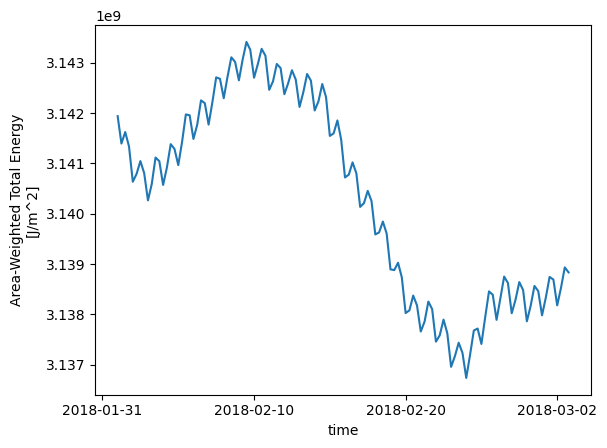

In [55]:
ds["aw_te"].plot()